In [1]:
import torch
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import numpy as np


import sys
import importlib
if 'clip' in sys.modules:
    del sys.modules['clip']
import clip


In [2]:
resnet50_imagenet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
clip_model, preprocess = clip.load("RN50")
clip_visual_encoder = clip_model.visual


In [3]:

print(resnet50_imagenet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:

print(clip_visual_encoder)

ModifiedResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

In [5]:
print("\nImageNet ResNet-50 Main Components:")
for name, module in resnet50_imagenet.named_children():
    print(f"{name}: {type(module).__name__}")

print("\nCLIP Visual Encoder Main Components:")
for name, module in clip_visual_encoder.named_children():
    print(f"{name}: {type(module).__name__}")


ImageNet ResNet-50 Main Components:
conv1: Conv2d
bn1: BatchNorm2d
relu: ReLU
maxpool: MaxPool2d
layer1: Sequential
layer2: Sequential
layer3: Sequential
layer4: Sequential
avgpool: AdaptiveAvgPool2d
fc: Linear

CLIP Visual Encoder Main Components:
conv1: Conv2d
bn1: BatchNorm2d
relu1: ReLU
conv2: Conv2d
bn2: BatchNorm2d
relu2: ReLU
conv3: Conv2d
bn3: BatchNorm2d
relu3: ReLU
avgpool: AvgPool2d
layer1: Sequential
layer2: Sequential
layer3: Sequential
layer4: Sequential
attnpool: AttentionPool2d


 the final layer adaptation in CLIP projects visual features into the shared multimodal embedding space rather than classifying them directly into ImageNet categories.

 The standard ResNet-50 was trained with cross-entropy loss for classification, CLIP's ResNet-50 was trained with contrastive loss to align image and text embeddings

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

weights = ResNet50_Weights.IMAGENET1K_V1
categories = weights.meta["categories"]

formatted_categories = [f"a photo of a {category}" for category in categories]

with torch.no_grad():
    text_features = model.encode_text(clip.tokenize(formatted_categories).to(device))
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)


In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


Top 5 predictions for image dog2.jpg:
Labrador retriever: 35.72%
    Walker hound: 10.39%
English foxhound: 9.03%
          beagle: 7.60%
Brittany spaniel: 4.61%

Top 5 predictions for image cat2.jpg:
           tabby: 33.33%
     Persian cat: 16.76%
            yawl: 8.69%
       tiger cat: 8.29%
  Madagascar cat: 2.82%

Top 5 predictions for image car2.jpg:
      sports car: 85.79%
     convertible: 8.50%
           racer: 1.84%
        golfcart: 0.55%
recreational vehicle: 0.41%


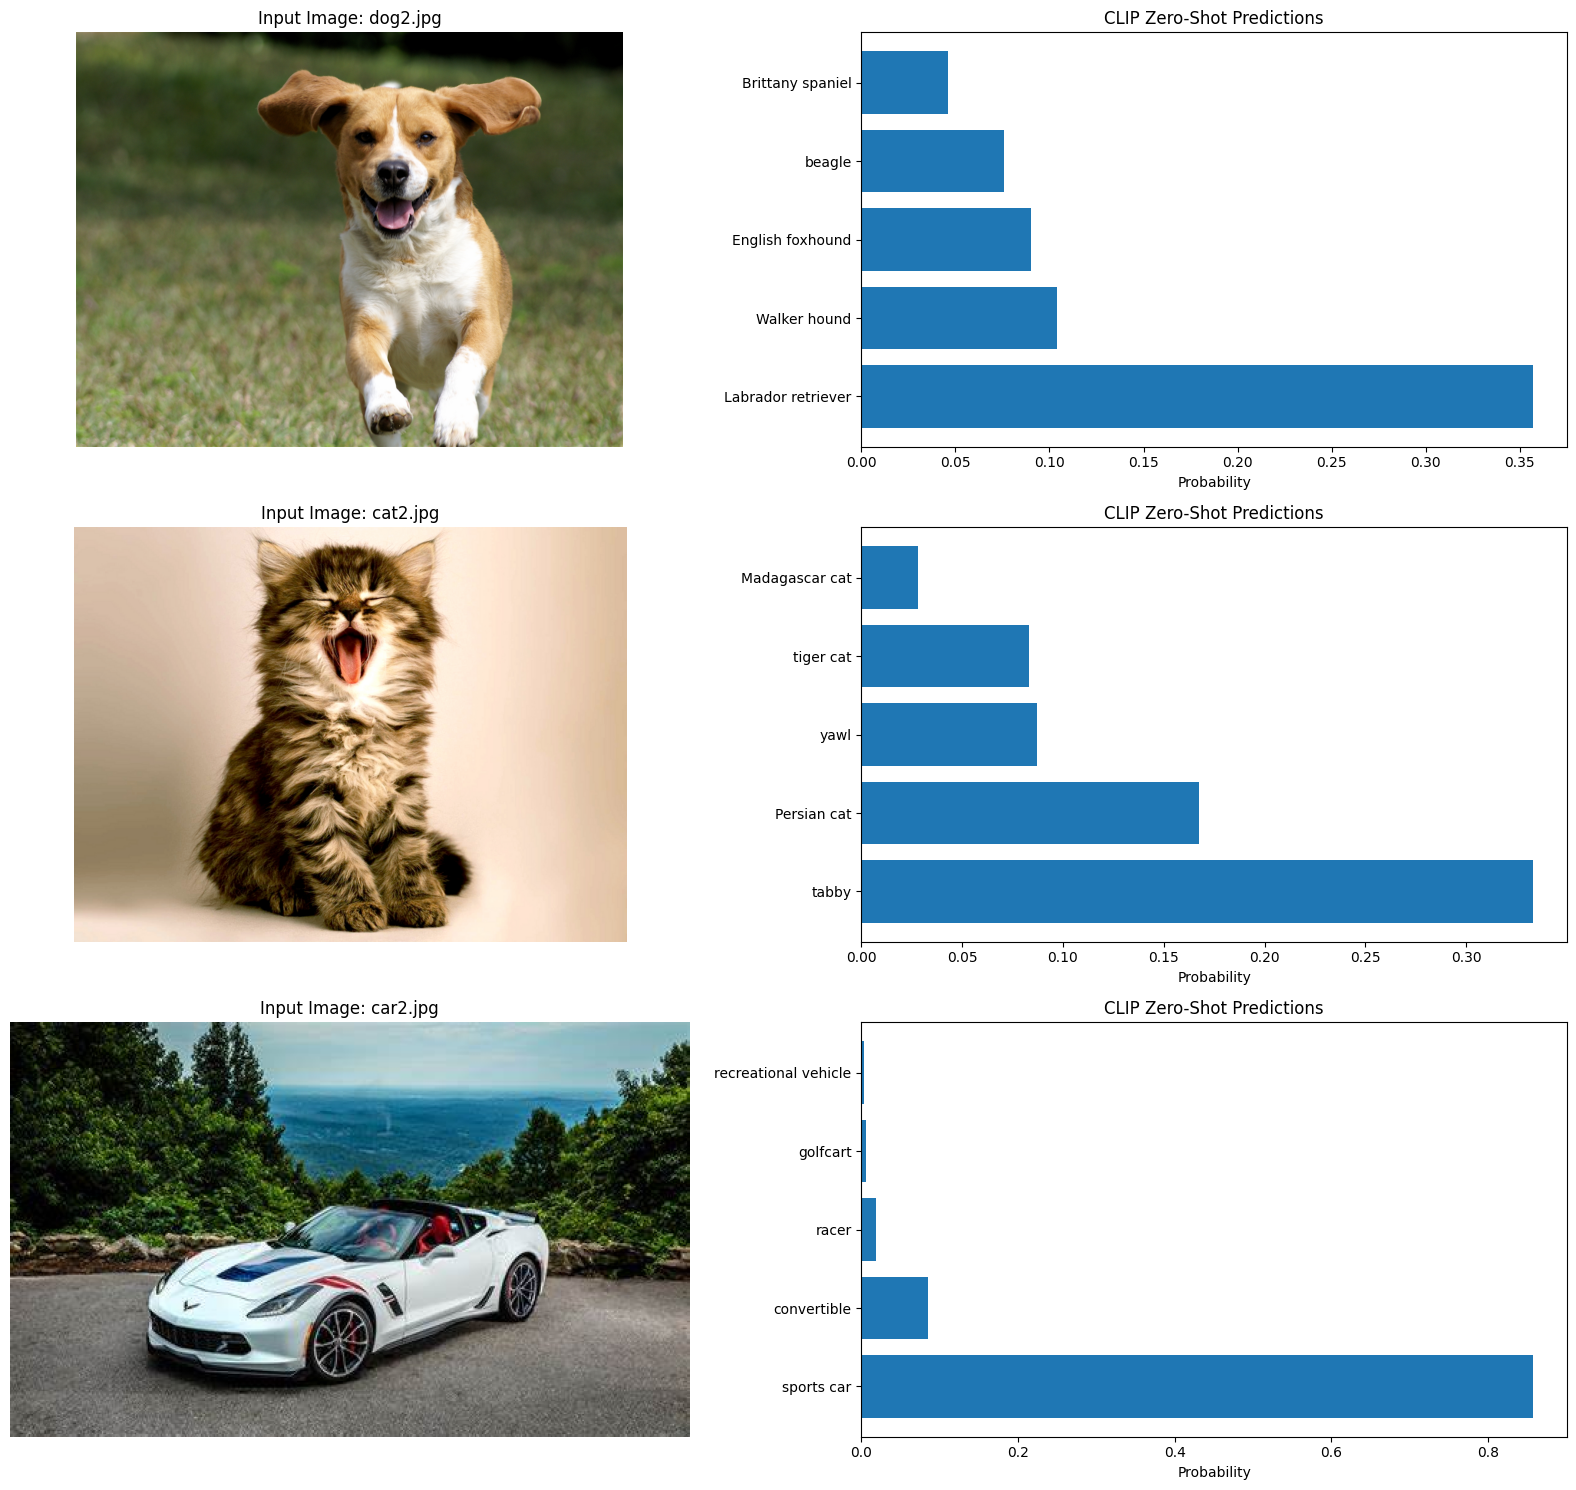

In [11]:
def classify_image_with_clip(image_path, top_k=5):
    image = Image.open(image_path)
    
    image_input = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    values, indices = similarity[0].topk(top_k)
    
    print(f"\nTop {top_k} predictions for image {os.path.basename(image_path)}:")
    for value, idx in zip(values, indices):
        print(f"{categories[idx]:>16s}: {100 * value.item():.2f}%")
    
    return image, values, indices

image_directory = "/home/walke/college/cv/ass5/q3"

example_images = [
    os.path.join(image_directory, "dog2.jpg"),
    os.path.join(image_directory, "cat2.jpg"),
    os.path.join(image_directory, "car2.jpg"),
]


valid_images = []
for img_path in example_images:
    if os.path.exists(img_path):
        valid_images.append(img_path)
    else:
        print(f"Warning: Image file not found: {img_path}")

if not valid_images:
    print("No valid image files found. Please check your file paths.")
else:
    plt.figure(figsize=(16, 5 * len(valid_images)))

    for i, img_path in enumerate(valid_images):
        img, values, indices = classify_image_with_clip(img_path)
        
        plt.subplot(len(valid_images), 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Input Image: {os.path.basename(img_path)}")
        plt.axis('off')
        
        plt.subplot(len(valid_images), 2, 2*i+2)
        y_pos = np.arange(len(values))
        plt.barh(y_pos, values.cpu().numpy(), align='center')
        plt.yticks(y_pos, [categories[idx] for idx in indices])
        plt.xlabel('Probability')
        plt.title('CLIP Zero-Shot Predictions')

    plt.tight_layout()
    plt.show()



In [12]:
resnet50_imagenet.eval()
resnet50_imagenet.to(device)
imagenet_preprocess = models.ResNet50_Weights.IMAGENET1K_V1.transforms()

selected_classes = {
    'tench': 0,           # Fish
    'hen': 8,             # Bird
    'Egyptian cat': 285,  # Cat
    'German shepherd': 235,  # Dog
    'monarch butterfly': 323,  # Insect
    'pizza': 963,         # Food
    'airliner': 404,      # Vehicle
    'desktop computer': 527,  # Electronic
    'barrel': 427,        # Object
    'cliff': 972,         # Natural landscape
}

clip_model, clip_preprocess = clip.load("RN50", device=device)

In [13]:
from PIL import Image
import torch.nn.functional as F
import os

In [14]:

def classify_with_both_models(image_path, true_class_name):


    
    image = Image.open(image_path)
        

    true_class_idx = selected_classes[true_class_name]
        

    clip_image = clip_preprocess(image).unsqueeze(0).to(device)
        
    imagenet_image = imagenet_preprocess(image).unsqueeze(0).to(device)
        
    with torch.no_grad():
            # CLIP inference
        image_features = clip_model.encode_image(clip_image)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        similarity = 100.0 * image_features @ text_features.T
        clip_probs = similarity.softmax(dim=-1)
            
            # ImageNet ResNet inference
        imagenet_outputs = resnet50_imagenet(imagenet_image)
        imagenet_probs = F.softmax(imagenet_outputs, dim=1)
        
    
    clip_values, clip_indices = clip_probs[0].topk(5)
    imagenet_values, imagenet_indices = imagenet_probs[0].topk(5)
        
    
    clip_success = true_class_idx in clip_indices.cpu().numpy()
    imagenet_success = true_class_idx in imagenet_indices.cpu().numpy()
        
  
    clip_rank = (clip_indices == true_class_idx).nonzero().item() + 1 if clip_success else "Not in top 5"
    imagenet_rank = (imagenet_indices == true_class_idx).nonzero().item() + 1 if imagenet_success else "Not in top 5"
        
      
    print(f"\nResults for class: {true_class_name}")
    print(f"Image: {os.path.basename(image_path)}")
    print(f"CLIP Success: {clip_success}, Rank: {clip_rank}")
    print(f"ImageNet Success: {imagenet_success}, Rank: {imagenet_rank}")
        
    print("\nCLIP Top 5 Predictions:")
    for value, idx in zip(clip_values, clip_indices):
        print(f"{categories[idx]:>16s}: {100 * value.item():.2f}%")
        
    print("\nImageNet Top 5 Predictions:")
    for value, idx in zip(imagenet_values, imagenet_indices):
        print(f"{categories[idx]:>16s}: {100 * value.item():.2f}%")
        

    result = {
            'image': image,
            'image_path': image_path,
            'true_class': true_class_name,
            'clip_success': clip_success,
            'imagenet_success': imagenet_success,
            'clip_predictions': [(categories[idx], value.item()) for idx, value in zip(clip_indices, clip_values)],
            'imagenet_predictions': [(categories[idx], value.item()) for idx, value in zip(imagenet_indices, imagenet_values)]
    }
        
    return result
    




ANALYZING CLASS: tench

Example where CLIP works but ImageNet fails:

Results for class: tench
Image: tenchdrawing.jpg
CLIP Success: True, Rank: 2
ImageNet Success: False, Rank: Not in top 5

CLIP Top 5 Predictions:
            coho: 56.93%
           tench: 6.80%
      barracouta: 6.09%
        sturgeon: 5.55%
          puffer: 3.75%

ImageNet Top 5 Predictions:
        envelope: 53.98%
            tray: 6.78%
     book jacket: 3.21%
            pick: 2.12%
          binder: 2.04%

Example where ImageNet works but CLIP fails:

Results for class: tench
Image: tench.jpg
CLIP Success: True, Rank: 1
ImageNet Success: True, Rank: 1

CLIP Top 5 Predictions:
           tench: 81.69%
            coho: 12.15%
             gar: 2.01%
          puffer: 1.59%
         buckeye: 0.44%

ImageNet Top 5 Predictions:
           tench: 99.42%
      barracouta: 0.21%
            coho: 0.11%
        sturgeon: 0.07%
             gar: 0.05%


ANALYZING CLASS: hen

Example where CLIP works but ImageNet fai

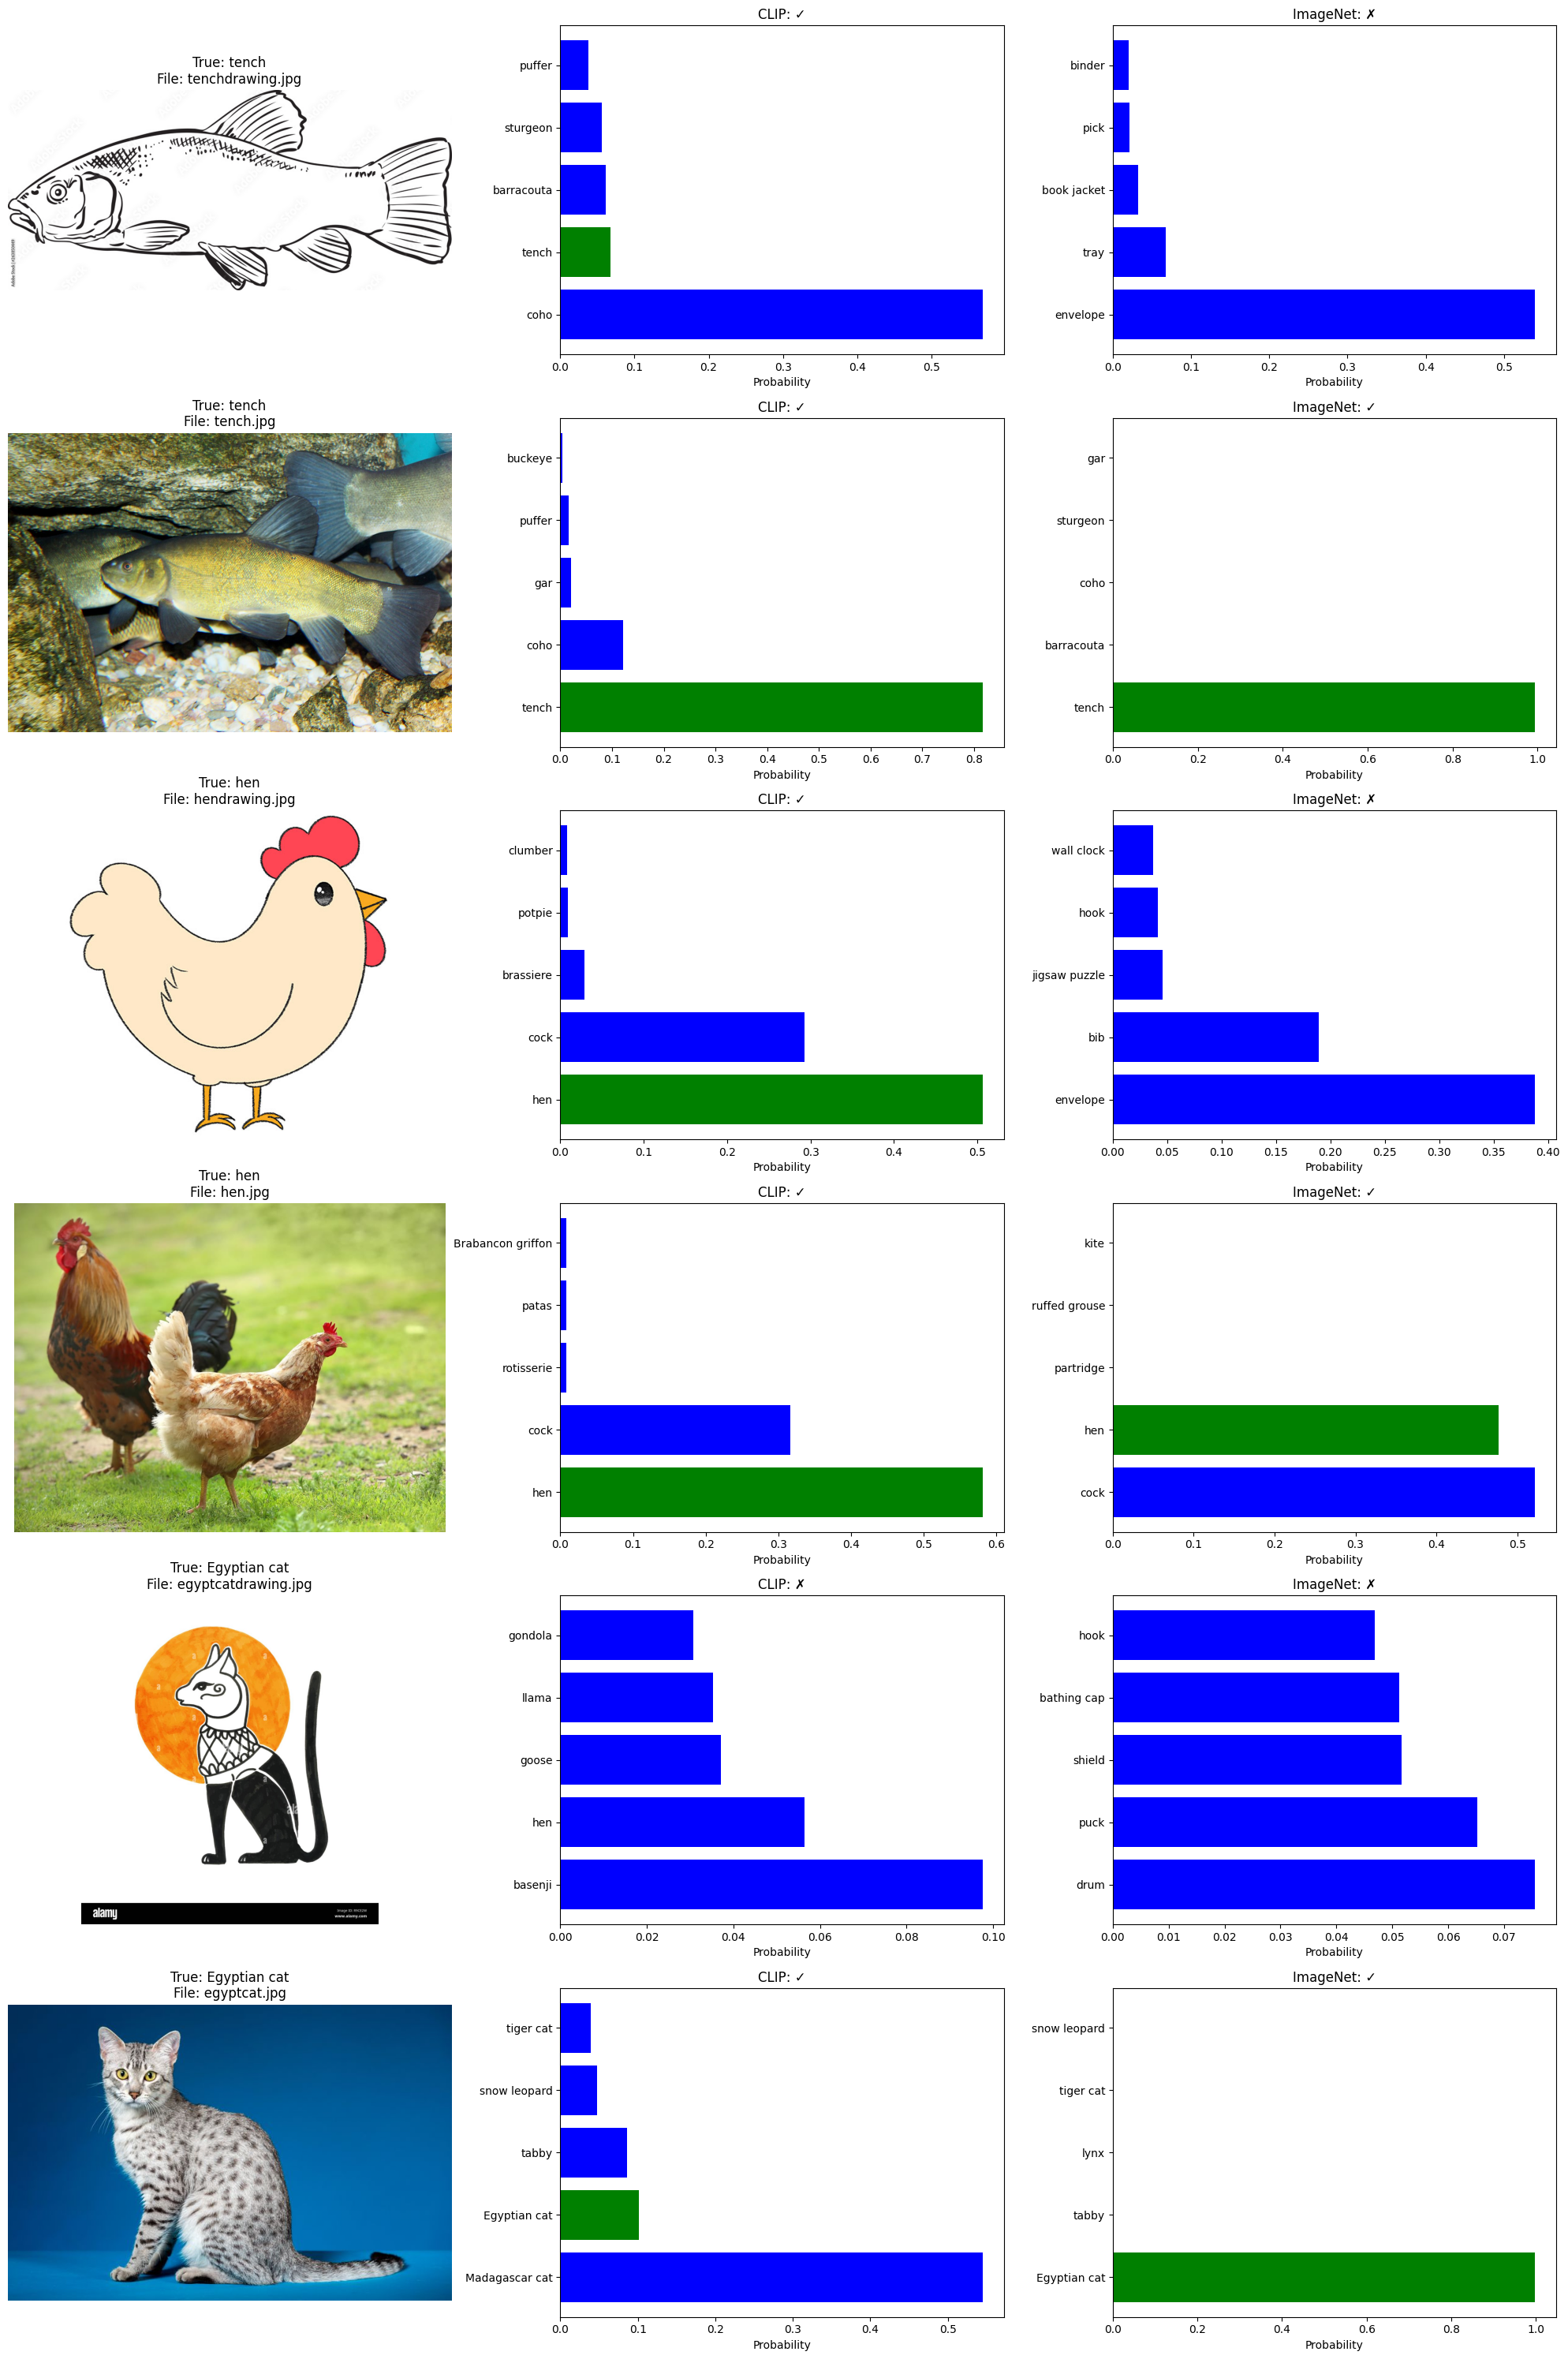

In [23]:

clip_dir = "/home/walke/college/cv/ass5/q3/clip"
resnet_dir = "/home/walke/college/cv/ass5/q3/resnet"


test_cases = [

    {
        'class': 'tench',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "tenchdrawing.jpg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "tench.jpg")  
        ]
    },
    
    # Class: hen
    {
        'class': 'hen',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir,"hendrawing.jpg"), 
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir,"hen.jpg")  
        ]
    },
    
    # Class: Egyptian cat
    {
        'class': 'Egyptian cat',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "egyptcatdrawing.jpg"), 
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "egyptcat.jpg") 
        ]
    },
    
    # Class: German shepherd
    {
        'class': 'German shepherd',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "gstoy.jpg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "gs.jpeg")  
        ]
    },
    
    # Class: monarch butterfly
    {
        'class': 'monarch butterfly',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "butterflydrawing.jpg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "butterfly.jpg")  
        ]
    },
    
    # Class: pizza
    {
        'class': 'pizza',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "pizza.jpg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "pizza.jpg")  
        ]
    },
    
    # Class: airliner
    {
        'class': 'airliner',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "airline.jpg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "airline.jpg") 
        ]
    },
    
    # Class: desktop computer
    {
        'class': 'desktop computer',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "computer.jpg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "computer.jpg")  
        ]
    },
    
    # Class: barrel
    {
        'class': 'barrel',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir,  "barrel.jpeg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir,  "barrel.jpg")  
        ]
    },
    
    # Class: cliff
    {
        'class': 'cliff',
        'clip_good_imagenet_bad': [
            os.path.join(clip_dir, "cliff.jpg"),  
        ],
        'imagenet_good_clip_bad': [
            os.path.join(resnet_dir, "cliff.jpg")  
        ]
    }
]

results = []
    
for case in test_cases:
    class_name = case['class']
    print(f"\n\n{'='*50}")
    print(f"ANALYZING CLASS: {class_name}")
    print(f"{'='*50}")
        
    
    print("\nExample where CLIP works but ImageNet fails:")
    clip_good_result = classify_with_both_models(case['clip_good_imagenet_bad'][0], class_name)
    if clip_good_result:
        results.append(clip_good_result)
        

    print("\nExample where ImageNet works but CLIP fails:")
    imagenet_good_result = classify_with_both_models(case['imagenet_good_clip_bad'][0], class_name)
    if imagenet_good_result:
        results.append(imagenet_good_result)


def plot_results(results_list, num_to_plot=6):
    
    results_to_plot = results_list[:min(num_to_plot, len(results_list))]
        
    plt.figure(figsize=(20, 5*len(results_to_plot)))
        
    for i, result in enumerate(results_to_plot):
            # Plot the image
        plt.subplot(len(results_to_plot), 3, 3*i+1)
        plt.imshow(result['image'])
        plt.title(f"True: {result['true_class']}\nFile: {os.path.basename(result['image_path'])}")
        plt.axis('off')
            
            # Plot CLIP predictions
        plt.subplot(len(results_to_plot), 3, 3*i+2)
        labels = [p[0] for p in result['clip_predictions']]
        values = [p[1] for p in result['clip_predictions']]
        y_pos = np.arange(len(labels))
        colors = ['green' if label == result['true_class'] else 'blue' for label in labels]
        plt.barh(y_pos, values, color=colors)
        plt.yticks(y_pos, labels)
        plt.xlabel('Probability')
        plt.title(f"CLIP: {'✓' if result['clip_success'] else '✗'}")
            
            # Plot ImageNet predictions
        plt.subplot(len(results_to_plot), 3, 3*i+3)
        labels = [p[0] for p in result['imagenet_predictions']]
        values = [p[1] for p in result['imagenet_predictions']]
        y_pos = np.arange(len(labels))
        colors = ['green' if label == result['true_class'] else 'blue' for label in labels]
        plt.barh(y_pos, values, color=colors)
        plt.yticks(y_pos, labels)
        plt.xlabel('Probability')
        plt.title(f"ImageNet: {'✓' if result['imagenet_success'] else '✗'}")
        
    plt.tight_layout()
    plt.show()

if results:
    plot_results(results)
    

Images where CLIP succeeds but ImageNet fails ->  Stylized representations, drawings, or art, Symbolic representations like icons

Images where ImageNet succeeds but CLIP fails -> Multiple instances of the object, Objects in unusual poses or viewpoints



CLIP was trained on image-text pairs so can understand conceptual relationships through language, ImageNet was trained with photographic examples for object detection, 


Loading FP32 model...
Loading FP16 model...

Processing image: cat
FP32 top classes: ['tabby', 'Persian cat', 'yawl', 'tiger cat', 'Madagascar cat']
FP16 top classes: ['tabby', 'Persian cat', 'yawl', 'tiger cat', 'Madagascar cat']
Max probability difference: 0.000822

Processing image: car
FP32 top classes: ['sports car', 'convertible', 'racer', 'golfcart', 'recreational vehicle']
FP16 top classes: ['sports car', 'convertible', 'racer', 'golfcart', 'recreational vehicle']
Max probability difference: 0.000722

Processing image: dog
FP32 top classes: ['Labrador retriever', 'Walker hound', 'English foxhound', 'beagle', 'Brittany spaniel']
FP16 top classes: ['Labrador retriever', 'Walker hound', 'English foxhound', 'beagle', 'Brittany spaniel']
Max probability difference: 0.003082


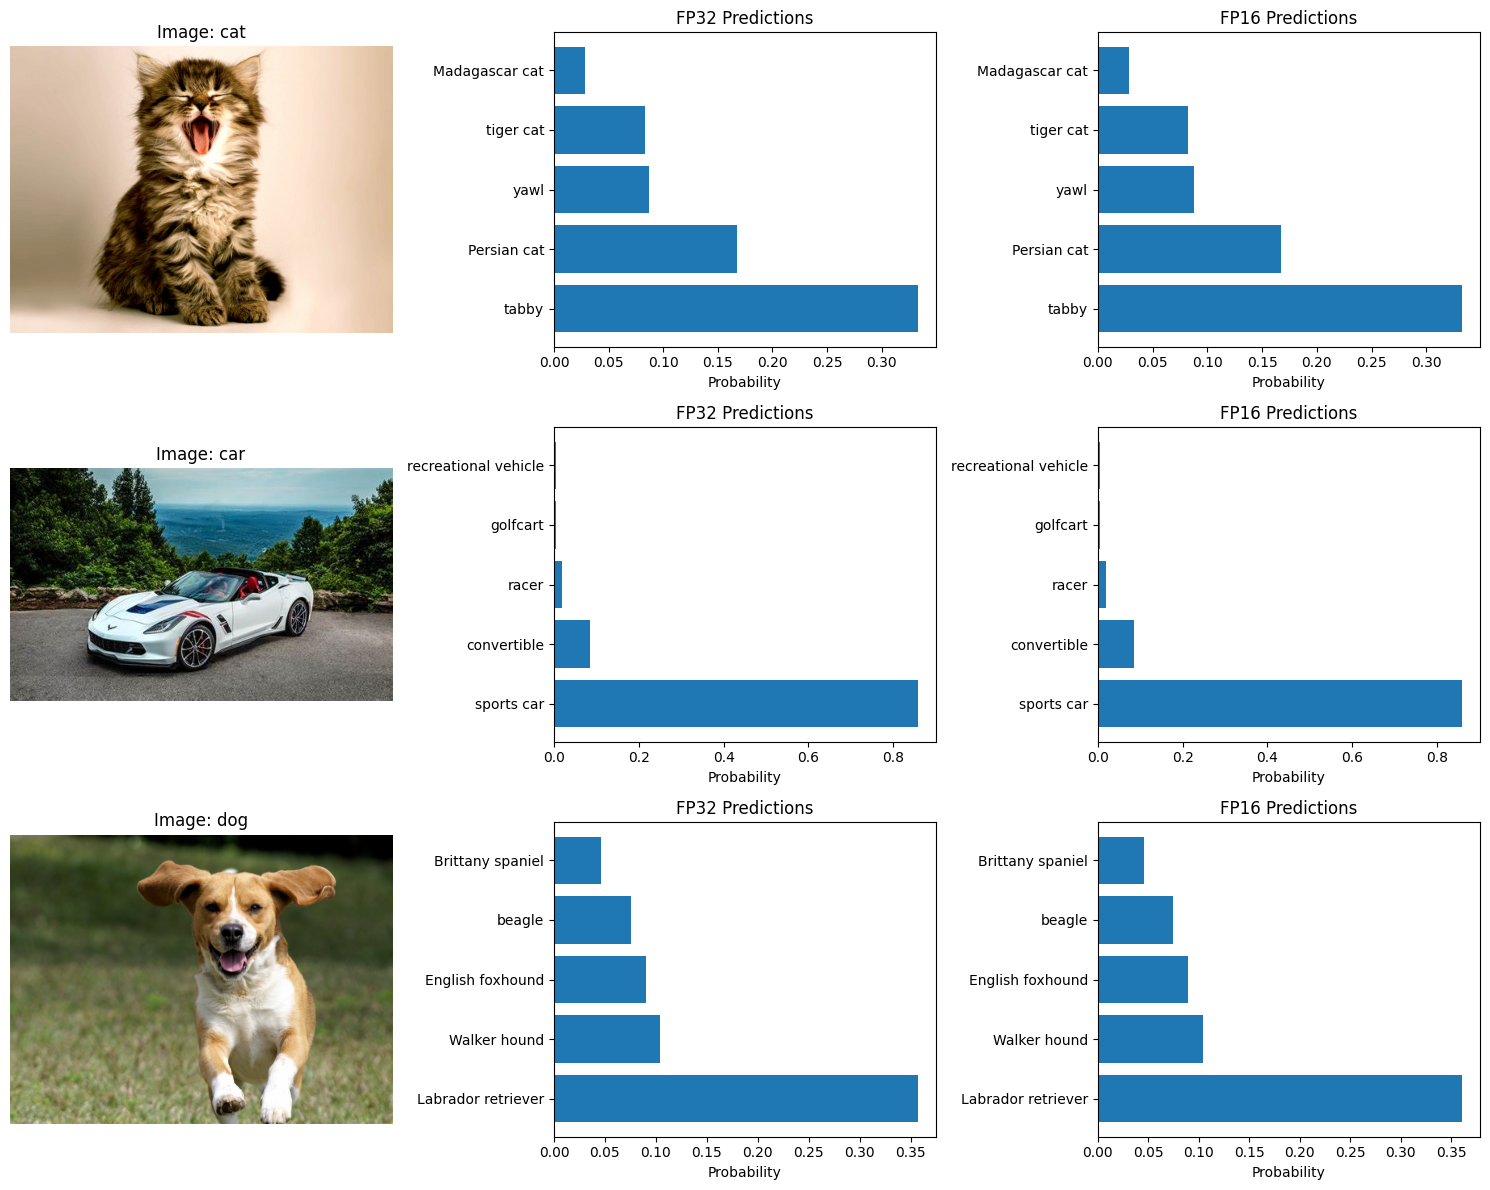


PERFORMANCE COMPARISON
Warming up for fp32...
Measuring fp32 performance over 50 runs...
Run 0/50
Run 10/50
Run 20/50
Run 30/50
Run 40/50
Warming up for fp16...


/tmp/ipykernel_281130/3808064426.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Measuring fp16 performance over 50 runs...
Run 0/50
Run 10/50
Run 20/50
Run 30/50
Run 40/50

Speed Results:
FP32: 18.46 ± 5.17 ms
FP16: 15.60 ± 3.20 ms
Speedup: 1.18x

Memory Results:
FP32: 1753.02 MB
FP16: 1753.02 MB
Memory reduction: 1.00x


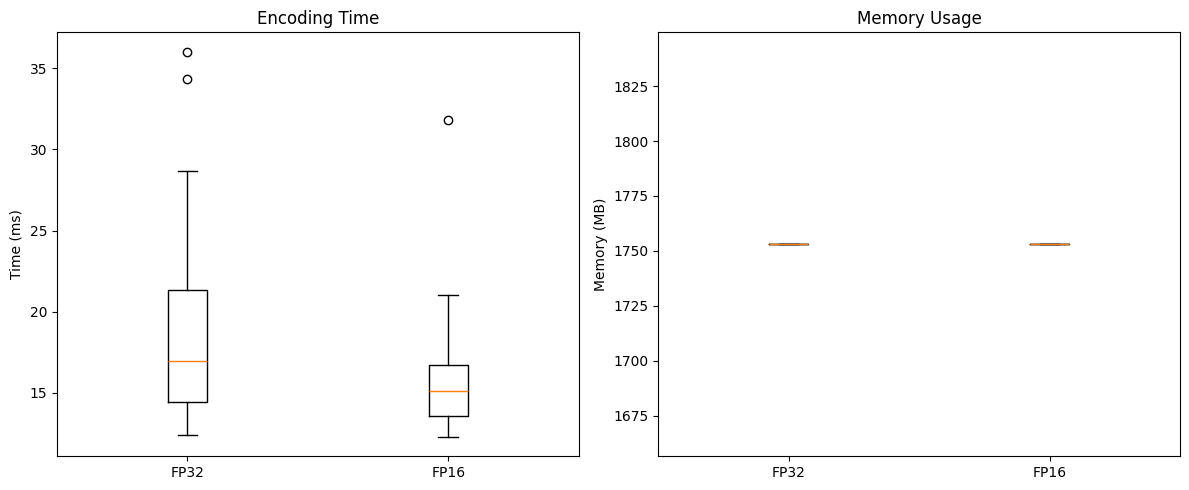

1. FP16 is about 1.2x faster than FP32
2. FP16 uses about 1.0x less memory than FP32


In [25]:

import time
import gc


test_images = [
    ("/home/walke/college/cv/ass5/q3/cat2.jpg", "cat"),
    ("/home/walke/college/cv/ass5/q3/car2.jpg", "car"),
    ("/home/walke/college/cv/ass5/q3/dog2.jpg", "dog"),
]

def measure_performance(model, preprocess, precision="fp32", num_runs=50):

    images = [Image.open(path) for path, _ in test_images]
    processed_images = [preprocess(img).unsqueeze(0).to(device) for img in images]
    

    print(f"Warming up for {precision}...")
    for img_tensor in processed_images:
        if precision == "fp16":
            with torch.cuda.amp.autocast():
                _ = model.encode_image(img_tensor)
        else:
            _ = model.encode_image(img_tensor)
    

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    print(f"Measuring {precision} performance over {num_runs} runs...")
    times = []
    memory = []
    
    for i in range(num_runs):
        if i % 10 == 0:
            print(f"Run {i}/{num_runs}")
        
        img_idx = i % len(processed_images)
        img_tensor = processed_images[img_idx]
        
        start = time.time()
        
  
        if precision == "fp16":
            with torch.amp.autocast('cuda'):
                _ = model.encode_image(img_tensor)
        else:
            _ = model.encode_image(img_tensor)
        
        torch.cuda.synchronize()
        
        times.append(time.time() - start)
        memory.append(torch.cuda.max_memory_allocated() / (1024 * 1024))  # MB
    
    return {
        "times": times,
        "memory": memory,
        "avg_time": np.mean(times),
        "std_time": np.std(times),
        "avg_memory": np.mean(memory),
        "std_memory": np.std(memory)
    }

def get_predictions(model, preprocess, image_path, precision="fp32", top_k=5):
 
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    text_prompts = [f"a photo of a {category}" for category in categories]
    
    with torch.no_grad():
        text_tokens = clip.tokenize(text_prompts).to(device)
        

        if precision == "fp16":
            with torch.amp.autocast('cuda'):
                text_features = model.encode_text(text_tokens)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        else:
            text_features = model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
       
        if precision == "fp16":
            with torch.amp.autocast('cuda'):
                image_features = model.encode_image(image_input)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        else:
            image_features = model.encode_image(image_input)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        
    
        values, indices = similarity[0].topk(top_k)
    
    return {
        "image": image,
        "probs": values.cpu().numpy(),
        "classes": [categories[idx] for idx in indices]
    }


def compare_outputs():

    print("Loading FP32 model...")
    model_fp32, preprocess = clip.load("RN50", device=device)
    
    print("Loading FP16 model...")
    model_fp16, _ = clip.load("RN50", device=device)
    
    results = []
    
    for path, label in test_images:
        print(f"\nProcessing image: {label}")
        
    
        fp32_preds = get_predictions(model_fp32, preprocess, path, precision="fp32")
        fp16_preds = get_predictions(model_fp16, preprocess, path, precision="fp16")
        
        fp32_probs = fp32_preds["probs"]
        fp16_probs = fp16_preds["probs"]
        prob_diff = np.abs(fp32_probs - fp16_probs)
        
        print(f"FP32 top classes: {fp32_preds['classes']}")
        print(f"FP16 top classes: {fp16_preds['classes']}")
        print(f"Max probability difference: {np.max(prob_diff):.6f}")
        
        results.append({
            "label": label,
            "fp32_classes": fp32_preds["classes"],
            "fp16_classes": fp16_preds["classes"],
            "fp32_probs": fp32_probs,
            "fp16_probs": fp16_probs,
            "max_diff": np.max(prob_diff),
            "image": fp32_preds["image"]
        })
    
    return results

def compare_performance():
    print("\n" + "="*50)
    print("PERFORMANCE COMPARISON")
    print("="*50)
    

    model_fp32, preprocess = clip.load("RN50", device=device)
    model_fp16, _ = clip.load("RN50", device=device)
    

    fp32_perf = measure_performance(model_fp32, preprocess, precision="fp32")
    fp16_perf = measure_performance(model_fp16, preprocess, precision="fp16")
    

    print("\nSpeed Results:")
    print(f"FP32: {fp32_perf['avg_time'] * 1000:.2f} ± {fp32_perf['std_time'] * 1000:.2f} ms")
    print(f"FP16: {fp16_perf['avg_time'] * 1000:.2f} ± {fp16_perf['std_time'] * 1000:.2f} ms")
    print(f"Speedup: {fp32_perf['avg_time'] / fp16_perf['avg_time']:.2f}x")
    
    print("\nMemory Results:")
    print(f"FP32: {fp32_perf['avg_memory']:.2f} MB")
    print(f"FP16: {fp16_perf['avg_memory']:.2f} MB")
    print(f"Memory reduction: {fp32_perf['avg_memory'] / fp16_perf['avg_memory']:.2f}x")
    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    

    ax1.boxplot([np.array(fp32_perf['times']) * 1000, np.array(fp16_perf['times']) * 1000])
    ax1.set_xticklabels(['FP32', 'FP16'])
    ax1.set_ylabel('Time (ms)')
    ax1.set_title('Encoding Time')
    

    ax2.boxplot([fp32_perf['memory'], fp16_perf['memory']])
    ax2.set_xticklabels(['FP32', 'FP16'])
    ax2.set_ylabel('Memory (MB)')
    ax2.set_title('Memory Usage')
    
    plt.tight_layout()
    plt.show()
    
    return {
        "fp32": fp32_perf,
        "fp16": fp16_perf
    }



output_comparison = compare_outputs()
    
plt.figure(figsize=(15, len(test_images) * 4))
    
for i, result in enumerate(output_comparison):

    plt.subplot(len(test_images), 3, 3*i + 1)
    plt.imshow(result['image'])
    plt.title(f"Image: {result['label']}")
    plt.axis('off')
        
    plt.subplot(len(test_images), 3, 3*i + 2)
    y_pos = np.arange(len(result['fp32_classes']))
    plt.barh(y_pos, result['fp32_probs'], align='center')
    plt.yticks(y_pos, result['fp32_classes'])
    plt.xlabel('Probability')
    plt.title('FP32 Predictions')
        
    plt.subplot(len(test_images), 3, 3*i + 3)
    y_pos = np.arange(len(result['fp16_classes']))
    plt.barh(y_pos, result['fp16_probs'], align='center')
    plt.yticks(y_pos, result['fp16_classes'])
    plt.xlabel('Probability')
    plt.title('FP16 Predictions')
    
plt.tight_layout()
plt.show()
    
performance_results = compare_performance()
    

print("1. FP16 is about {:.1f}x faster than FP32".format(
        performance_results['fp32']['avg_time'] / performance_results['fp16']['avg_time']))
print("2. FP16 uses about {:.1f}x less memory than FP32".format(
        performance_results['fp32']['avg_memory'] / performance_results['fp16']['avg_memory']))




- ImageNet uses WordNet's hierarchical structure with parent-child relationships between object categories
- A synset (synonym set) is a group of words representing the same concept/meaning
- synsets can cause problems because visually distinct objects get grouped together
- Three visual differences in the same synset: lighting/color variation, perspective/angle changes, and object part visibility/occlusion